In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import preprocess
import group_calc
import factor_analysis
from data_process import get_csv_files
import warnings
from tqdm import tqdm
import random
warnings.filterwarnings('ignore')

class ChipDistribution():

    def __init__(self):
        self.Chip = {} # 当前获利盘
        self.ChipList = {}  # 所有的获利盘的

    def get_data(self,file):
        self.data = pd.read_csv(file)

    def calcuJUN(self,dateT,highT, lowT, volT, TurnoverRateT, A, minD):

        x =[]
        l = (highT - lowT) / minD
        for i in range(int(l)):
            x.append(round(lowT + i * minD, 2))
        length = len(x)
        eachV = volT/length
        for i in self.Chip:
            self.Chip[i] = self.Chip[i] *(1 -TurnoverRateT * A)
        for i in x:
            if i in self.Chip:
                self.Chip[i] += eachV *(TurnoverRateT * A)
            else:
                self.Chip[i] = eachV *(TurnoverRateT * A)
        import copy
        self.ChipList[dateT] = copy.deepcopy(self.Chip)



    def calcuSin(self,dateT,highT, lowT,avgT, volT,TurnoverRateT,minD,A):
        x =[]

        l = (highT - lowT) / minD
        for i in range(int(l)):
            x.append(round(lowT + i * minD, 2))

        length = len(x)

        #计算仅仅今日的筹码分布
        tmpChip = {}
        eachV = volT/length


        #极限法分割去逼近
        for i in x:
            x1 = i
            x2 = i + minD
            h = 2 / (highT - lowT)
            s= 0
            if i < avgT:
                y1 = h /(avgT - lowT) * (x1 - lowT)
                y2 = h /(avgT - lowT) * (x2 - lowT)
                s = minD *(y1 + y2) /2
                s = s * volT
            else:
                y1 = h /(highT - avgT) *(highT - x1)
                y2 = h /(highT - avgT) *(highT - x2)

                s = minD *(y1 + y2) /2
                s = s * volT
            tmpChip[i] = s


        for i in self.Chip:
            self.Chip[i] = self.Chip[i] *(1 -TurnoverRateT * A)

        for i in tmpChip:
            if i in self.Chip:
                self.Chip[i] += tmpChip[i] *(TurnoverRateT * A)
            else:
                self.Chip[i] = tmpChip[i] *(TurnoverRateT * A)
        import copy
        self.ChipList[dateT] = copy.deepcopy(self.Chip)


    def calcu(self,dateT,highT, lowT,avgT, volT, TurnoverRateT,minD = 0.01, flag=1 , AC=1):
        if flag ==1:
            self.calcuSin(dateT,highT, lowT,avgT, volT, TurnoverRateT,A=AC, minD=minD)
        elif flag ==2:
            self.calcuJUN(dateT,highT, lowT, volT, TurnoverRateT, A=AC, minD=minD)

    def calcuChip(self, flag=1, AC=1):  #flag 使用哪个计算方式,    AC 衰减系数
        low = self.data['low']
        high = self.data['high']
        vol = self.data['volume']
        TurnoverRate = self.data['TurnoverRate']
        avg = self.data['avg']
        date = self.data['trade_date']

        for i in range(len(date)):
        #     if i < 90:
        #         continue

            highT = high[i]
            lowT = low[i]
            volT = vol[i]
            TurnoverRateT = TurnoverRate[i]
            avgT = avg[i]
            # print(date[i])
            dateT = date[i]
            self.calcu(dateT,highT, lowT,avgT, volT, TurnoverRateT/100, flag=flag, AC=AC)  # 东方财富的小数位要注意，兄弟萌。我不除100懵逼了

        # 计算winner
    def winner(self,p=None):
            Profit = []
            date = self.data['trade_date']

            if p == None:  # 不输入默认close
                p = self.data['close']
                count = 0
                for i in self.ChipList:
                    # 计算目前的比例

                    Chip = self.ChipList[i]
                    total = 0
                    be = 0
                    for i in Chip:
                        total += Chip[i]
                        if i < p[count]:
                            be += Chip[i]
                    if total != 0:
                        bili = be / total
                    else:
                        bili = 0
                    count += 1
                    Profit.append(bili)
            else:
                for i in self.ChipList:
                    # 计算目前的比例

                    Chip = self.ChipList[i]
                    total = 0
                    be = 0
                    for i in Chip:
                        total += Chip[i]
                        if i < p:
                            be += Chip[i]
                    if total != 0:
                        bili = be / total
                    else:
                        bili = 0
                    Profit.append(bili)


            return Profit

    def lwinner(self,N = 5, p=None):

        data = copy.deepcopy(self.data)
        date = data['trade_date']
        ans = []
        for i in range(len(date)):
            if i < N:
                ans.append(None)
                continue
            self.data = data[i-N:i]
            self.data.index= range(0,N)
            self.__init__()
            self.calcuChip()    #使用默认计算方式
            a = self.winner(p)
            ans.append(a[-1])
        

        self.data = data
        return ans



    def cost(self,N):
        date = self.data['trade_date']

        N = N / 100  # 转换成百分比
        ans = []
        for i in self.ChipList:  # ChipList本身就有顺序
            Chip = self.ChipList[i]
            ChipKey = sorted(Chip.keys())  # 排序
            total = 0  # 当前比例
            sumOf = 0  # 所有筹码的总和
            for j in Chip:
                sumOf += Chip[j]

            for j in ChipKey:
                tmp = Chip[j]
                tmp = tmp / sumOf
                total += tmp
                if total > N:
                    ans.append(j)
                    break
        
        return ans
    
    def cal_factor(self, lower_bound, upper_bound):
        factors = {}
        last_factor_value = None  # 用于保存上一期的因子值
        date = self.data['trade_date']
        for i in sorted(self.ChipList.keys()):  # 确保按日期顺序处理
            Chip = self.ChipList[i]

            price_series = self.data.loc[date == i, 'close']
            if price_series.empty:
                if last_factor_value is not None:  # 如果上一期有因子值，则使用它
                    factors[i] = last_factor_value
                continue  # 如果没有找到价格，跳过当前日期

            price = price_series.iloc[0]
            ChipKey = sorted(Chip.keys())  # 排序
            total = 0
            sumOf = sum(Chip[j] for j in Chip)
            for j in ChipKey:
                if (j - price) <= price * upper_bound and (j - price) >= price * lower_bound:
                    total += Chip[j]

            if sumOf != 0:
                factors[i] = total / sumOf
                last_factor_value = factors[i]  
            else:
                if factors:
                    factors[i] = list(factors.values())[-1].copy()
                    last_factor_value = factors[i]  

        return factors



In [2]:
def add_factor(file_path,name_bound):
    files = get_csv_files(file_path)
    merged_df = pd.DataFrame()
    for file in tqdm(files):
        a=ChipDistribution()
        a.get_data(file) #获取数据
        a.calcuChip(flag=1, AC=1) #计算
        a.winner() #获利盘
        a.cost(90) #成本分布
        a.lwinner(N=1500)
        profit = a.winner()
        data = a.data
        
        for name,bound in name_bound.items():
            lower_bound = bound[0]
            upper_bound = bound[1]
            factor = a.cal_factor(lower_bound,upper_bound)
            if len(factor.values()) == len(data['stock_code']):
                data[name] = factor.values()
            else:
                print('数据长短不一')
                
        if len(profit) == len(data['stock_code']):
            data['profit_percentage'] = profit
        else:
            print('数据长短不一') 
            
        merged_df =pd.concat([merged_df,data],ignore_index=True)
    return merged_df
file_path = './data/data'

name_bound = {'factor_resistance':[0.03,0.1],
              'factor_supporting':[-0.1,-0.03],
              'factor_wave':[-0.03,0.03]}
merged_df = add_factor(file_path,name_bound)



 18%|█▊        | 19/105 [04:15<13:44,  9.59s/it] 

数据长短不一
数据长短不一


 19%|█▉        | 20/105 [04:49<24:18, 17.16s/it]

数据长短不一


100%|██████████| 105/105 [39:47<00:00, 22.74s/it]


In [3]:
merged_df

,stock_code,stock,trade_date,open,high,low,close,volume,ret,avg,TurnoverRate,factor_resistance,factor_supporting,factor_wave,profit_percentage
0,600008.SH,首创环保,2019-01-02,3.49,3.53,3.41,3.43,16549705,0.0000,3.4627,0.3433,0.000000,0.000000,1.000000,0.063084
1,600008.SH,首创环保,2019-01-03,3.45,3.46,3.35,3.37,15516423,-1.7493,3.3982,0.3219,0.158698,0.000000,0.841302,0.035533
2,600008.SH,首创环保,2019-01-04,3.34,3.43,3.32,3.43,16063455,1.7804,3.3910,0.3332,0.000000,0.004262,0.995738,0.633790
3,600008.SH,首创环保,2019-01-07,3.46,3.52,3.44,3.49,16925583,1.7493,3.4846,0.3511,0.000000,0.219406,0.780594,0.867121
4,600008.SH,首创环保,2019-01-08,3.48,3.49,3.44,3.45,10497523,-1.1461,3.4616,0.2178,0.000000,0.024955,0.975045,0.494711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139276,600202.SH,哈空调,2024-06-25,3.49,3.50,3.40,3.46,3850700,1.7647,3.4530,1.0045,0.112979,0.001453,0.056495,0.009955
139277,600202.SH,哈空调,2024-06-26,3.43,3.58,3.40,3.57,4998000,3.1792,3.4709,1.3038,0.083458,0.013566,0.121738,0.062744
139278,600202.SH,哈空调,2024-06-27,3.57,3.62,3.53,3.55,4195100,-0.5602,3.5659,1.0944,0.082021,0.009163,0.120293,0.048191
139279,600202.SH,哈空调,2024-06-28,3.49,3.62,3.49,3.57,4262679,0.5634,3.5751,1.1120,0.082848,0.013467,0.128157,0.066221


In [11]:
merged_df['factor_resistance'] = merged_df['factor_resistance'].fillna(0)
merged_df['factor_supporting'] = merged_df['factor_supporting'].fillna(0)
merged_df['factor_wave'] = merged_df['factor_wave'].fillna(0)
merged_df = merged_df.rename(columns = {'pct_chg':'ret'},inplace = True)
merged_df.to_csv('data_df.csv')

SyntaxError: invalid syntax (3387685757.py, line 4)

In [14]:
factor_df = merged_df[['trade_date','stock_code','factor_resistance','factor_supporting','factor_wave','profit_percentage']]
factor_df = preprocess.standardize(factor_df, 'factor_resistance', method='zscore')
factor_df = preprocess.standardize(factor_df, 'factor_supporting', method='zscore')
factor_df = preprocess.standardize(factor_df, 'factor_wave', method='zscore')
factor_df = preprocess.standardize(factor_df, 'profit_percentage', method='zscore')

factor_df['trade_date'] = pd.to_datetime(factor_df['trade_date'], format="%Y-%m-%d")
factor_df['trade_date'] = factor_df['trade_date'].dt.strftime("%Y%m%d")

ret_df = merged_df[['trade_date','stock_code','ret']]
ret_df['trade_date'] = pd.to_datetime(ret_df['trade_date'], format="%Y-%m-%d")
ret_df['ret'] = ret_df['ret']/100
ret_df['trade_date'] = ret_df['trade_date'].dt.strftime("%Y%m%d")

ret_df.to_csv('ret_df.csv')
factor_df.to_csv('factor_df.csv')

factor_single_df = factor_df[['trade_date','stock_code','factor_wave']]
mw_group_ret = group_calc.get_group_ret(factor_single_df,ret_df, 'factor_wave', 5)
mw_group_ret

,Group0,Group1,Group2,Group3,Group4,H-L
20190103,-0.020843,-0.007621,0.000000,0.000000,0.000636,0.021479
20190104,0.037148,0.025410,0.016248,0.022563,0.014670,-0.022478
20190107,0.015809,0.019111,0.016461,0.012762,0.009005,-0.006804
20190108,-0.002552,0.002693,-0.002545,-0.002596,-0.000380,0.002171
20190109,-0.002389,-0.000873,0.006223,0.007166,0.005171,0.007560
...,...,...,...,...,...,...
20240625,-0.002439,-0.000418,0.004992,-0.004661,-0.005654,-0.003215
20240626,0.024658,0.017123,0.019361,0.009442,0.001232,-0.023426
20240627,-0.020213,-0.009696,-0.021940,-0.013551,-0.010573,0.009640
20240628,-0.002936,0.006877,0.003847,0.012265,0.015600,0.018536


In [15]:
factor_analysis.newy_west_test(mw_group_ret['H-L'],'factor_wave')

x is valid.


{'factor_name': ['factor_wave'],
 'ret_mean(%)': [-0.037],
 't-value': [-1.429],
 'p-value': [0.153],
 'p-star': [None]}

          因子名称      IC均值     IC标准差      IR比率  IC>0的比例(%)  IC>0.02的比例(%)
0  factor_wave -0.010015  0.142914 -0.070079   47.182569      41.923366


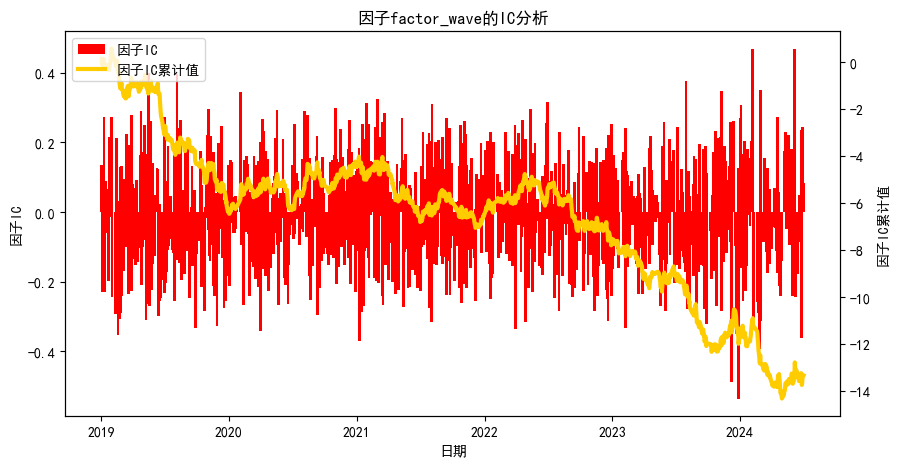

In [16]:
ic_dct, ic_fig = factor_analysis.analysis_factor_ic(factor_single_df, ret_df, 'factor_wave')
print(pd.DataFrame(ic_dct))
ic_fig

In [17]:
from datetime import datetime
benchmark = pd.read_csv('000888.SH.CSV')
benchmark['trade_date'] = pd.to_datetime(benchmark['trade_date'], format="%Y/%m/%d")
benchmark['trade_date'] = benchmark['trade_date'].dt.strftime("%Y%m%d")
benchmark['ret'] = benchmark['ret']/100
benchmark.to_csv('000888.SH_processed.CSV')
ew_backtest_df,ew_fig1,ew_fig2=group_calc.analysis_group_ret(factor_single_df, ret_df, 'factor_wave', n_groups=5, benchmark=benchmark, mktmv_df=None)
ew_backtest_df

                Group0     Group1     Group2     Group3     Group4        H-L  \
年化收益率(%)      2.083550   6.877323  -7.493243  -6.165916  -7.766175 -11.011237   
年化波动率(%)     21.172135  21.157632  19.679503  19.033431  19.384853  15.158783   
夏普比率          0.098410   0.325052  -0.380764  -0.323952  -0.400631  -0.726393   
最大回撤(%)     -23.051035 -23.106704 -26.326376 -28.356105 -25.267730 -36.280837   
超额年化收益率(%)    7.796666  12.858723  -2.316093  -0.914482  -2.604299  -6.030972   
超额年化波动率(%)   12.529091  12.544269  11.058656  10.493709  12.358417  22.906125   
信息比率          0.622285   1.025068  -0.209437  -0.087146  -0.210731  -0.263291   
相对基准胜率(%)    54.485050  54.817276  50.664452  51.328904  48.837209  49.335548   
超额收益最大回撤(%) -16.809903 -11.853607 -22.899626 -18.961107 -21.073970 -43.885772   

             benchmark  
年化收益率(%)     -5.299901  
年化波动率(%)     15.055323  
夏普比率         -0.352028  
最大回撤(%)     -21.517693  
超额年化收益率(%)    0.000000  
超额年化波动率(%)    0.000000  
信息比率          

,Group0,Group1,Group2,Group3,Group4,H-L,benchmark
年化收益率(%),2.083550,6.877323,-7.493243,-6.165916,-7.766175,-11.011237,-5.299901
年化波动率(%),21.172135,21.157632,19.679503,19.033431,19.384853,15.158783,15.055323
夏普比率,0.098410,0.325052,-0.380764,-0.323952,-0.400631,-0.726393,-0.352028
最大回撤(%),-23.051035,-23.106704,-26.326376,-28.356105,-25.267730,-36.280837,-21.517693
超额年化收益率(%),7.796666,12.858723,-2.316093,-0.914482,-2.604299,-6.030972,0.000000
超额年化波动率(%),12.529091,12.544269,11.058656,10.493709,12.358417,22.906125,0.000000
信息比率,0.622285,1.025068,-0.209437,-0.087146,-0.210731,-0.263291,0.000000
相对基准胜率(%),54.485050,54.817276,50.664452,51.328904,48.837209,49.335548,0.000000
超额收益最大回撤(%),-16.809903,-11.853607,-22.899626,-18.961107,-21.073970,-43.885772,0.000000


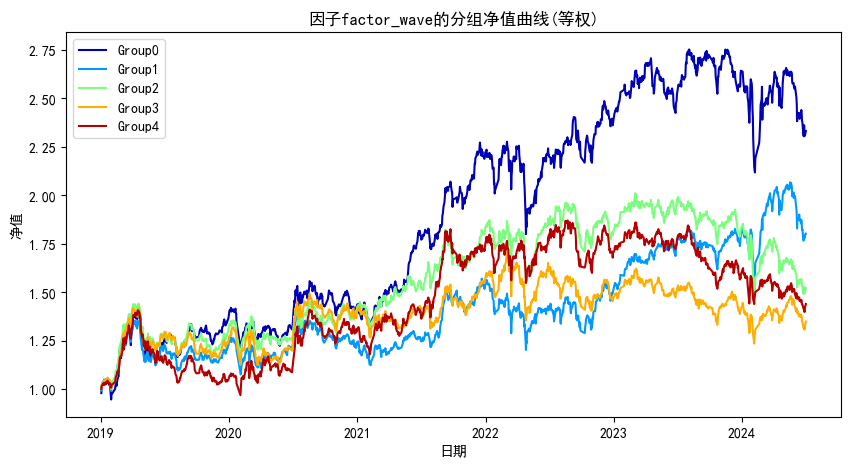

In [18]:
ew_fig1

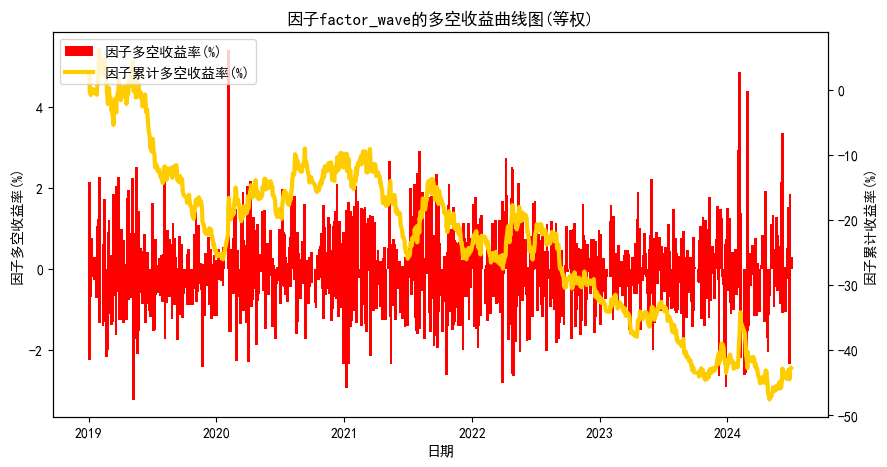

In [19]:
ew_fig2

In [20]:
import pandas as pd
import tushare as ts
import time
ts.set_token('6ddb307225c1b26eaabecc4e76561c9305d5bcad10bb6b882a3e63df')
pro = ts.pro_api()
# 查询股票基本信息
data = pro.query('stock_basic', exchange='', list_status='L',
                 fields='ts_code,name,list_date')

# 剔除包含ST的股票
sts = data[data['name'].str.contains('ST', regex=True)]['name'].values.tolist()
data = data[~data['name'].isin(sts)]

# 剔除创业板的股票
cys = data['ts_code'].str.contains('^30', regex=True).tolist()
data = data[~data['ts_code'].isin(cys)]

# 剔除科创板的股票
kcs = data['ts_code'].str.contains('^68', regex=True).tolist()
data = data[~data['ts_code'].isin(kcs)]

# 剔除上市时间短于2年的股票
data = data[data['list_date'] < '20220701']

# 获取当前日期
now_time = time.strftime('%Y%m%d')

# 剔除停牌股
tp_df = pro.suspend_d(suspend_type='S', trade_date=now_time)
tp_list = tp_df['ts_code'].values.tolist()
data = data[~data['ts_code'].isin(tp_list)]
selected_stock = data[['ts_code','name']]
stock_code = selected_stock
stock_code

,ts_code,name
0,000001.SZ,平安银行
1,000002.SZ,万科A
2,000004.SZ,国华网安
3,000006.SZ,深振业A
4,000007.SZ,全新好
...,...,...
5317,871981.BJ,晶赛科技
5325,872925.BJ,锦好医疗
5333,873169.BJ,七丰精工
5334,873223.BJ,荣亿精密


In [25]:
merged_df

,Unnamed: 0,stock_code,stock,trade_date,open,high,low,close,volume,ret,avg,TurnoverRate,factor_resistance,factor_supporting,factor_wave,profit_percentage
0,0,600008.SH,首创环保,2019-01-02,3.49,3.53,3.41,3.43,16549705,0.0000,3.4627,0.3433,0.000000,0.000000,1.000000,0.063084
1,1,600008.SH,首创环保,2019-01-03,3.45,3.46,3.35,3.37,15516423,-1.7493,3.3982,0.3219,0.158698,0.000000,0.841302,0.035533
2,2,600008.SH,首创环保,2019-01-04,3.34,3.43,3.32,3.43,16063455,1.7804,3.3910,0.3332,0.000000,0.004262,0.995738,0.633790
3,3,600008.SH,首创环保,2019-01-07,3.46,3.52,3.44,3.49,16925583,1.7493,3.4846,0.3511,0.000000,0.219406,0.780594,0.867121
4,4,600008.SH,首创环保,2019-01-08,3.48,3.49,3.44,3.45,10497523,-1.1461,3.4616,0.2178,0.000000,0.024955,0.975045,0.494711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139276,139276,600202.SH,哈空调,2024-06-25,3.49,3.50,3.40,3.46,3850700,1.7647,3.4530,1.0045,0.112979,0.001453,0.056495,0.009955
139277,139277,600202.SH,哈空调,2024-06-26,3.43,3.58,3.40,3.57,4998000,3.1792,3.4709,1.3038,0.083458,0.013566,0.121738,0.062744
139278,139278,600202.SH,哈空调,2024-06-27,3.57,3.62,3.53,3.55,4195100,-0.5602,3.5659,1.0944,0.082021,0.009163,0.120293,0.048191
139279,139279,600202.SH,哈空调,2024-06-28,3.49,3.62,3.49,3.57,4262679,0.5634,3.5751,1.1120,0.082848,0.013467,0.128157,0.066221


In [38]:
merged_df = pd.read_csv('data_df.csv')
merged_df = merged_df.loc[merged_df['stock_code'].isin(stock_code['ts_code'])] 
merged_df[(merged_df['factor_resistance']<=0.05)& (merged_df['profit_percentage']<=0.3)& (merged_df['profit_percentage']>= 0.2)&
          (merged_df['factor_supporting']>=0.1)& (merged_df['factor_supporting']<=0.3)& (merged_df['factor_wave']>= 0.1) ]


,Unnamed: 0,stock_code,stock,trade_date,open,high,low,close,volume,ret,avg,TurnoverRate,factor_resistance,factor_supporting,factor_wave,profit_percentage
3914,3914,600010.SH,包钢股份,2024-02-29,1.51,1.54,1.51,1.54,234222496,1.3158,1.5273,0.7436,0.043971,0.148751,0.180717,0.276529
3920,3920,600010.SH,包钢股份,2024-03-08,1.55,1.56,1.52,1.54,331166899,-1.2821,1.5389,1.0514,0.042100,0.138631,0.235335,0.287606
3921,3921,600010.SH,包钢股份,2024-03-11,1.53,1.55,1.53,1.54,221417714,0.0000,1.5401,0.7030,0.041726,0.137400,0.242123,0.287272
4363,4363,600011.SH,华能国际,2020-07-09,4.75,4.81,4.70,4.78,53844554,0.6316,4.7587,0.4896,0.029711,0.137763,0.166377,0.289522
11105,11105,600018.SH,上港集团,2020-11-10,4.95,4.97,4.68,4.75,122782000,-2.8630,4.7722,0.5298,0.011790,0.116946,0.221145,0.255977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131305,131305,600135.SH,乐凯胶片,2019-01-24,6.33,6.34,6.20,6.24,3065300,-0.4785,6.2461,0.8218,0.044584,0.113660,0.841756,0.290146
132555,132555,600135.SH,乐凯胶片,2024-03-22,6.40,6.43,6.24,6.30,6128726,-1.5625,6.3126,1.1077,0.023076,0.100670,0.105278,0.281256
135551,135551,600138.SH,中青旅,2020-02-11,10.45,10.57,10.35,10.36,19428513,-1.3333,10.4442,2.6841,0.007829,0.177238,0.117524,0.235517
135553,135553,600138.SH,中青旅,2020-02-13,10.52,10.61,10.40,10.41,16901442,-1.8850,10.4901,2.3350,0.014282,0.172963,0.158442,0.237742
